# Sentiment Classification


## Loading the dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.datasets import imdb
import numpy as np

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

Using TensorFlow backend.


In [3]:
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

## Train test split

In [4]:
#load dataset as a list of ints
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

In [5]:
print ('X_train contains', x_train.shape[0], 'rows and', x_train.shape[1], 'columns.')
print ('y_train contains', y_train.shape[0], 'rows.')
print ('X_test contains', x_test.shape[0], 'rows and', x_test.shape[1], 'columns.')
print ('y_test contains', y_test.shape[0], 'rows.')

X_train contains 25000 rows and 300 columns.
y_train contains 25000 rows.
X_test contains 25000 rows and 300 columns.
y_test contains 25000 rows.


In [6]:
train_len = [len(sequence) for sequence in x_train]
test_len = [len(sequence) for sequence in x_test]
print('Maximum value of a word index:', max([max(sequence) for sequence in x_train]))
print('Maximum length num words of review in train:', max([len(sequence) for sequence in x_train]))

Maximum value of a word index: 9999
Maximum length num words of review in train: 300


In [7]:
unique, counts = np.unique(np.concatenate((y_train, y_test)), return_counts=True)
sentiments = {1: 'Positive', 0: 'Negative'}

def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
review_id1 = np.random.choice(train_len)
interprete_review(x_train[review_id1])
print('The sentiment for the above review is:', sentiments.get(y_train[review_id1]))
print('\n')
review_id2 = np.random.choice(test_len)
interprete_review(x_test[review_id2])
print('The sentiment for the above review is:', sentiments.get(y_test[review_id2]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? who made this film i love this film somebody has a wacky sense of humor br br this zany surreal style of film making is appealing but it is hard to create or easy to forget that substance and characters who actually have souls are what give such a film depth without that a comedy is just a bunch of ideas who cares it may get laughs but it goes through you like a half good ? next br br ? may not intend to change ? life but i appreciate the depth and substance they sneak up on you i started this film thinking oh i get it indie comedy off the wall ? ? and it is that but if you pay attention there is sub text and character moments filling it out in this sense the film ? it makes ? that give pause if you're available to see them and then of course it goes on its insanely merry way br br you will miss the point if you don't sign the contract to suspe

## Build Keras Embedding Layer Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.sequence import pad_sequences

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

### Artificial Neural Network

In [9]:
embedding_dim = 300
# Build the network
ann = Sequential()
ann.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
ann.add(Flatten())
ann.add(Dense(1, activation = 'sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 90001     
Total params: 3,090,001
Trainable params: 3,090,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 5
batches = 512
#using 20% of data as validation set
history = ann.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 8s 381us/step - loss: 0.6524 - accuracy: 0.6197 - val_loss: 0.5276 - val_accuracy: 0.7736
Epoch 2/5
20000/20000 [==============================] - 8s 385us/step - loss: 0.3539 - accuracy: 0.8715 - val_loss: 0.3277 - val_accuracy: 0.8666
Epoch 3/5
20000/20000 [==============================] - 8s 381us/step - loss: 0.1940 - accuracy: 0.9365 - val_loss: 0.2955 - val_accuracy: 0.8762
Epoch 4/5
20000/20000 [==============================] - 8s 388us/step - loss: 0.1174 - accuracy: 0.9739 - val_loss: 0.2791 - val_accuracy: 0.8822
Epoch 5/5
20000/20000 [==============================] - 8s 382us/step - loss: 0.0702 - accuracy: 0.9905 - val_loss: 0.2808 - val_accuracy: 0.8864


In [11]:
tr_loss, tr_acc = ann.evaluate(x_train, y_train)
print('Training Loss: %.4f and Accuracy: %.2f%%' % (tr_loss, tr_acc * 100))

loss, acc = ann.evaluate(x_test, y_test)
print('Test Loss: %.4f and Accuracy: %.2f%%' % (loss, acc * 100))

25000/25000 [==============================] - 4s 150us/step
Training Loss: 0.0952 and Accuracy: 97.38%
25000/25000 [==============================] - 4s 151us/step
Test Loss: 0.2892 and Accuracy: 87.95%


**Observations**:
 - ANN seems to be working good 87.95% test score.
 - However, we can clearly see the differences for loss and accuracy between the training and validation sets. This indicates      that the model is overfitting.

Testing accuracy: 87.952

 Confusion matrix:
 [[11148  1352]
 [ 1660 10840]]


Text(0.5, 1, 'Confusion Matrix HeatMap')

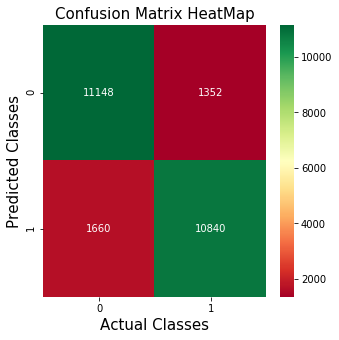

In [12]:
y_pred = ann.predict_classes(x_test)

print('Testing accuracy:', (accuracy_score(y_test, y_pred) * 100))

cfm_ann = confusion_matrix(y_test, y_pred)
print('\n Confusion matrix:\n', cfm_ann)

plt.figure(figsize = (5, 5))
sns.heatmap(cfm_ann, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15)

In [13]:
print('Classification report:\n', (classification_report(y_test, y_pred)))

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     12500
           1       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [14]:
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

Precision-Recall Curve


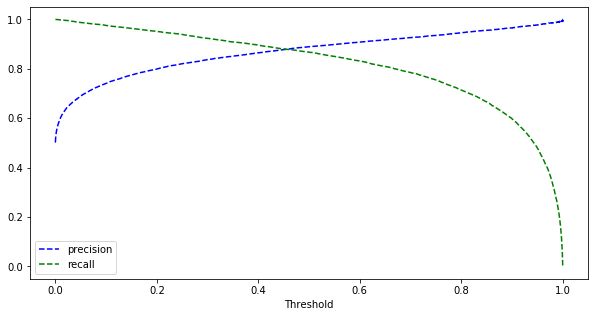

In [15]:
y_proba = ann.predict_proba(x_test)
print('Precision-Recall Curve')
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plot_prec_recall_vs_thresh(precision, recall, thresholds)

### Recurrent Neural Network (LSTM)

In [16]:
lstm = Sequential()
lstm.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, activation = 'tanh', dropout = 0.2,
               kernel_constraint = unit_norm(),
               recurrent_constraint = unit_norm(),
               bias_constraint = unit_norm()))
lstm.add(Dense(150, activation = 'relu')) 
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation = 'sigmoid'))
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               19350     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 3,239,149
Trainable params: 3,239,149
Non-trainable params: 0
____________________________________________

In [17]:
epochs = 5
batches = 128
#using 20% of data as validation set
history = lstm.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_split = 0.2) 

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 235s 12ms/step - loss: 0.4610 - accuracy: 0.7742 - val_loss: 0.3272 - val_accuracy: 0.8662
Epoch 2/5
20000/20000 [==============================] - 249s 12ms/step - loss: 0.2664 - accuracy: 0.8961 - val_loss: 0.3159 - val_accuracy: 0.8692
Epoch 3/5
20000/20000 [==============================] - 254s 13ms/step - loss: 0.1832 - accuracy: 0.9317 - val_loss: 0.3374 - val_accuracy: 0.8544
Epoch 4/5
20000/20000 [==============================] - 248s 12ms/step - loss: 0.1310 - accuracy: 0.9523 - val_loss: 0.4055 - val_accuracy: 0.8562
Epoch 5/5
20000/20000 [==============================] - 251s 13ms/step - loss: 0.1173 - accuracy: 0.9571 - val_loss: 0.4703 - val_accuracy: 0.8602


In [18]:
tr_loss, tr_acc = lstm.evaluate(x_train, y_train)
print('Training Loss: %.4f and Accuracy: %.2f%%' % (tr_loss, tr_acc * 100))

loss, acc = lstm.evaluate(x_test, y_test)
print('Test Loss: %.4f and Accuracy: %.2f%%' % (loss, acc * 100))

25000/25000 [==============================] - 88s 4ms/step
Training Loss: 0.1338 and Accuracy: 96.00%
25000/25000 [==============================] - 88s 4ms/step
Test Loss: 0.4922 and Accuracy: 85.64%


**Observations**:
 - LSTM seems to be working good 85.64% test score.
 - However, we can clearly see the differences for loss and accuracy between the training and validation sets. This indicates      that the model is overfitting.


Testing accuracy: 85.64

 Confusion matrix:
 [[10966  1534]
 [ 2056 10444]]


Text(0.5, 1, 'Confusion Matrix HeatMap')

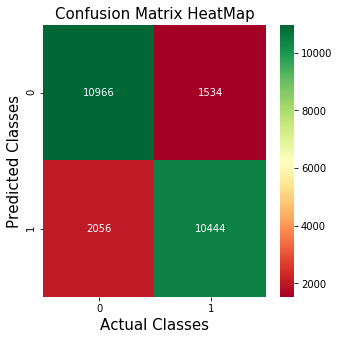

In [19]:
y_pred = lstm.predict_classes(x_test)

print('\nTesting accuracy:', (accuracy_score(y_test, y_pred) * 100))

cfm_lstm = confusion_matrix(y_test, y_pred)
print('\n Confusion matrix:\n', cfm_lstm)

plt.figure(figsize = (5, 5))
sns.heatmap(cfm_lstm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15)

In [20]:
print('Classification report:\n', (classification_report(y_test, y_pred)))

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86     12500
           1       0.87      0.84      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



Precision-Recall Curve


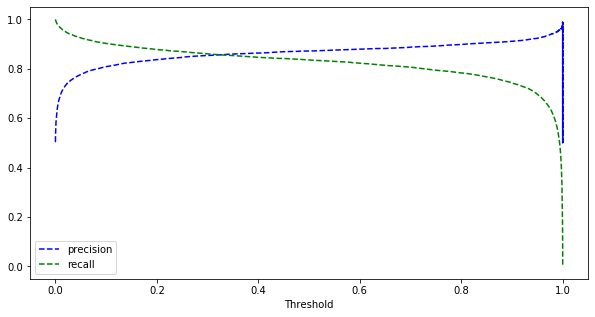

In [21]:
y_proba = lstm.predict_proba(x_test)
print('Precision-Recall Curve')
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plot_prec_recall_vs_thresh(precision, recall, thresholds)

In [22]:
# Predicting the sentiment for a random pre-defined review from IMDB dataset
review_id = np.random.choice(test_len)
interprete_review(x_test[review_id])
print('ACTUAL sentiment:', sentiments.get(y_test[review_id]))

prediction = lstm.predict_classes(pad_sequences([x_test[review_id]], maxlen = maxlen))
print('PREDICTED sentiment:', sentiments.get(prediction[0][0]))

reminding her that he is no longer in charge masters agrees to let her work in the ? position but the good doctor may not be who she seems br br the assortment of ? includes sam bill ? a simple minded child man who was last victim of ? jennifer warren a woman who needs an adult to comfort her as she ? at ? ? like a puppy danny jessie ? a trouble making annoyance often trying to steal the fake baby of disturbed harriet ? ? ? betty chandler a sexy ? who just wants to be loved and ? at any man she sees sergeant hugh your typical case of soldier who hasn't escaped the madness of war br br the film shows ? ? methods of running the clinic with allowing the patients to ? free with the doors to all rooms without locks calling into question and not to mention the fact that oliver is still allowed to walk around despite just ? dr ? with an axe and what exactly happened to dr ? ah ha br br tacky 70's drive in trash is a lot of fun if you are into a ? brand of cinema i'm attracted to bizarre flick

## Retrive the output of each layer in keras for a given single test sample from the trained model you built

In [23]:
def getLayerOutput(layer):
    get_Layer_Output = K.function([lstm.layers[0].input], [layer.output])
    return get_Layer_Output([x_test[0:1,]])[0]

layer_output = []

for layer in lstm.layers:
    layer_output.append(getLayerOutput(layer)) 
print('Number of layers: ', len(layer_output))

Number of layers:  6


First Layer

In [24]:
layer_output[0]

array([[[-0.04600979,  0.05687004,  0.0541437 , ...,  0.02336666,
         -0.01689279,  0.03023888],
        [-0.04600979,  0.05687004,  0.0541437 , ...,  0.02336666,
         -0.01689279,  0.03023888],
        [-0.04600979,  0.05687004,  0.0541437 , ...,  0.02336666,
         -0.01689279,  0.03023888],
        ...,
        [ 0.03308086,  0.01463704,  0.02404016, ..., -0.02637682,
          0.00324587,  0.03152347],
        [ 0.0258281 ,  0.00520924,  0.05482312, ...,  0.00676691,
          0.02192018, -0.03070826],
        [ 0.07136095, -0.06934713, -0.06874968, ...,  0.07189719,
         -0.02909005,  0.00921396]]], dtype=float32)

Second Layer

In [25]:
layer_output[1]

array([[[-0.04600979,  0.05687004,  0.0541437 , ...,  0.02336666,
         -0.01689279,  0.03023888],
        [-0.04600979,  0.05687004,  0.0541437 , ...,  0.02336666,
         -0.01689279,  0.03023888],
        [-0.04600979,  0.05687004,  0.0541437 , ...,  0.02336666,
         -0.01689279,  0.03023888],
        ...,
        [ 0.03308086,  0.01463704,  0.02404016, ..., -0.02637682,
          0.00324587,  0.03152347],
        [ 0.0258281 ,  0.00520924,  0.05482312, ...,  0.00676691,
          0.02192018, -0.03070826],
        [ 0.07136095, -0.06934713, -0.06874968, ...,  0.07189719,
         -0.02909005,  0.00921396]]], dtype=float32)

Third Layer

In [26]:
layer_output[2]

array([[ 0.01465092,  0.00150848,  0.03858656,  0.09951133,  0.10603142,
        -0.17450692, -0.01842631,  0.04627249, -0.07267568, -0.06789155,
        -0.13843375,  0.06273872,  0.07964303, -0.08275598, -0.10260823,
         0.14570592, -0.00679269, -0.09925042,  0.0302361 , -0.04031031,
        -0.13470316,  0.00819963, -0.01704836,  0.0576844 ,  0.07803832,
         0.01449214, -0.02640571,  0.11244917, -0.00255682,  0.03306483,
        -0.0216875 , -0.15333396, -0.09788684, -0.05940216,  0.02818561,
         0.04185301, -0.03087132, -0.04196547, -0.05019698, -0.01900594,
         0.01377458,  0.0297521 , -0.05793287,  0.02311623, -0.0694814 ,
         0.10167489,  0.11021487, -0.11720751,  0.06525832,  0.08449246,
        -0.02947626,  0.06382833, -0.02149672, -0.0392676 ,  0.04805572,
        -0.06864006, -0.02077019, -0.08611925,  0.05675567, -0.07186709,
         0.02566888,  0.01303599,  0.05514632, -0.01413956,  0.01255608,
         0.06668299,  0.0574863 ,  0.09437095,  0.0

Fourth Layer

In [27]:
layer_output[3]

array([[0.        , 0.        , 0.        , 0.        , 0.56989837,
        0.36116347, 0.        , 0.        , 0.4650783 , 0.        ,
        0.        , 0.        , 0.41387692, 0.        , 0.26730984,
        0.4492946 , 0.        , 0.39270884, 0.        , 0.        ,
        0.        , 0.42044833, 0.        , 0.        , 0.        ,
        0.376233  , 0.34405696, 0.4655919 , 0.        , 0.33408293,
        0.3695579 , 0.        , 0.4738658 , 0.        , 0.        ,
        0.45933646, 0.32021165, 0.40302   , 0.47862205, 0.49069923,
        0.        , 0.        , 0.47534007, 0.        , 0.43859902,
        0.        , 0.48179042, 0.        , 0.        , 0.37146586,
        0.291933  , 0.        , 0.10202432, 0.3875678 , 0.        ,
        0.        , 0.3392171 , 0.39093527, 0.        , 0.32987836,
        0.00299991, 0.        , 0.5021954 , 0.42885688, 0.4097584 ,
        0.45439503, 0.        , 0.381155  , 0.        , 0.        ,
        0.        , 0.4923333 , 0.37180424, 0.  

Fifth Layer

In [28]:
layer_output[4]

array([[0.        , 0.        , 0.        , 0.        , 0.56989837,
        0.36116347, 0.        , 0.        , 0.4650783 , 0.        ,
        0.        , 0.        , 0.41387692, 0.        , 0.26730984,
        0.4492946 , 0.        , 0.39270884, 0.        , 0.        ,
        0.        , 0.42044833, 0.        , 0.        , 0.        ,
        0.376233  , 0.34405696, 0.4655919 , 0.        , 0.33408293,
        0.3695579 , 0.        , 0.4738658 , 0.        , 0.        ,
        0.45933646, 0.32021165, 0.40302   , 0.47862205, 0.49069923,
        0.        , 0.        , 0.47534007, 0.        , 0.43859902,
        0.        , 0.48179042, 0.        , 0.        , 0.37146586,
        0.291933  , 0.        , 0.10202432, 0.3875678 , 0.        ,
        0.        , 0.3392171 , 0.39093527, 0.        , 0.32987836,
        0.00299991, 0.        , 0.5021954 , 0.42885688, 0.4097584 ,
        0.45439503, 0.        , 0.381155  , 0.        , 0.        ,
        0.        , 0.4923333 , 0.37180424, 0.  

Sixth Layer

In [29]:
layer_output[5]

array([[0.01542229]], dtype=float32)